# TEAM AWESOME

Team Awesome were:  Andrea Cremese, Dan Horner, Dayantha Kodituwakku, Keith McCammon, Morgan Sinclaire

<img src="http://brilliantbuthumble.com/share/cognitivebuilder/Slide01.jpg">

<img src="http://brilliantbuthumble.com/share/cognitivebuilder/Slide02.jpg">

<img src="http://brilliantbuthumble.com/share/cognitivebuilder/Slide03.jpg">

<img src="http://brilliantbuthumble.com/share/cognitivebuilder/Slide04.jpg">

# Pulling Seattle Traffic Data into DSX

In [1]:
import requests
import pandas as pd 
import matplotlib.pyplot as plt
import datetime
%matplotlib inline

In [2]:
### Two traffic datasets: traffic and 911

In [3]:
traffic_uri="https://data.seattle.gov/api/views/7ayk-pspk/rows.json?accessType=DOWNLOAD"
# We gave up on the offenses data: different date range. We wanted it to confirm timestamps on teh first dataset
offensetypes_uri="https://data.seattle.gov/api/views/6thv-9ipt.json?accessType=DOWNLOAD"

Build a dataframe from traffic incidents  
The json object returns data and column labels separately

In [ ]:
response=requests.get(traffic_uri)
print response.status_code
s=response.json()
meta=s['meta']['view']
data=s['data']
columns=meta['columns']
field_names=[ column['fieldName'] for column in columns ]

df=pd.DataFrame(data=data,columns=field_names)
df.to_csv("traffic_incidents.csv")

In [ ]:
df.to_csv("traffic_incidents.csv")

In [ ]:
### Cutpoint -- Save data to file system and load it back again

In [4]:
df=pd.DataFrame.from_csv("traffic_incidents.csv")

In [5]:
df.shape

(39195, 22)

In [6]:
df.head().transpose()

,0,1,2,3,4
:sid,18,57,224,230,320
:id,228B08D0-9D11-4F83-AB75-87C10E45AE4C,1607E543-D2EE-45EB-8CFD-FA9ADA5548BB,18793811-09E9-41F9-B3EA-5A92B2FA2857,4FC6F870-5621-4154-8DD9-3B8A3E56E64E,6AF6B7D2-21BB-40B3-98B3-943348FF7F19
:position,18,57,224,230,320
:created_at,1389368155,1389368155,1389368155,1389368155,1389368155
:created_meta,386118,386118,386118,386118,386118
:updated_at,1389368155,1389368155,1389368155,1389368155,1389368155
:updated_meta,386118,386118,386118,386118,386118
:meta,{\n},{\n},{\n},{\n},{\n}
cad_cdw_id,15753,15793,15964,15970,16061
cad_event_number,10000246384,10000246108,10000246619,10000246808,10000246102


### Clean up dataset

- Drop useless columns

In [7]:
df=df.drop([ column for column in df.columns if column.startswith(':') or column.startswith('cad')], axis=1)

 - Parse lat and long as floats 
 - Parse the clearance times into the 'date' column

In [8]:
x=df[['latitude','longitude']].apply( pd.to_numeric )
df['clearance_date']=(pd.to_datetime(df['event_clearance_date']))
df['hour'] = df['clearance_date'].apply(lambda d: d.hour)
df['date'] = df['clearance_date'].apply(lambda d: d.date())

In [9]:
df=df.drop('event_clearance_date',axis=1)

## Get weather data

This code queries the weather api for a specific date range. Repeated queries are used to build up the results in 30-day chunks

In [10]:
class WeatherQuery:
    #Seattle
    lat = "47.4444"
    lon = "-122.3139"
    units = "m"
    apiKey = "IBM_API_KEY_GOES_HERE"
    
    def formatDate(self,date):
        return "%d%02d%02d"%(date.year,date.month,date.day)
    
    def makeQuery(self, startDate,endDate=None):
        """ 
        Perform the request. Start/end are datetimes within 30 days of each other 
        """
        startDate = self.formatDate(startDate)
        if endDate is None:
            endDate = startDate
        else:
            endDate = self.formatDate(endDate)
            
        print("%r %r"%(startDate,endDate))
        
        url = "http://api.weather.com/v1/geocode/" + str(self.lat) + "/" + str(self.lon)+ \
            "/observations/historical.json?apiKey=" + self.apiKey + \
            "&units=" + self.units + \
            "&startDate="+str(startDate) + \
            "&endDate="+str(endDate)
            
        r = requests.get(url)
        if (r.status_code // 100 != 2 ):
            raise Exception( "Bad stuff: %s %s"%(r.status_code, r.text))
                
        return r.json()
    
    def weatherForRange(self,from_, to_):
        """
        the master method. Makes multpile calls to makeQuery
        """
        results = []
        startTime = from_
        while ( startTime <= to_ ):
            endTime = min( startTime + datetime.timedelta(days=30), to_ )
            j=self.makeQuery(startTime,endTime)
            results.append( pd.DataFrame.from_records(j['observations']) )
            startTime = startTime + datetime.timedelta(days=30)
        
        return pd.concat(results)
        

In [ ]:
weather = WeatherQuery()
weather_df = weather.weatherForRange(min(df.date),max(df.date))

clean up weather data

In [ ]:
weather_df.to_csv("weather_data.csv")

In [ ]:
### Cut point --- Save the data and read it back again

In [11]:
weather_df=pd.read_csv("weather_data.csv")

In [12]:
weather_df.keys()

Index([u'Unnamed: 0', u'blunt_phrase', u'class', u'clds', u'day_ind', u'dewPt',
       u'expire_time_gmt', u'feels_like', u'gust', u'heat_index', u'icon_extd',
       u'key', u'max_temp', u'min_temp', u'obs_id', u'obs_name',
       u'precip_hrly', u'precip_total', u'pressure', u'pressure_desc',
       u'pressure_tend', u'primary_swell_direction', u'primary_swell_height',
       u'primary_swell_period', u'primary_wave_height', u'primary_wave_period',
       u'qualifier', u'qualifier_svrty', u'rh', u'secondary_swell_direction',
       u'secondary_swell_height', u'secondary_swell_period', u'snow_hrly',
       u'temp', u'terse_phrase', u'uv_desc', u'uv_index', u'valid_time_gmt',
       u'vis', u'water_temp', u'wc', u'wdir', u'wdir_cardinal', u'wspd',
       u'wx_icon', u'wx_phrase'],
      dtype='object')

In [ ]:
weather_df['wx_phrase'].value_counts()

In [13]:
weather_df = weather_df[["valid_time_gmt", "precip_hrly", "precip_total","wx_phrase"]]
weather_df = weather_df.fillna(0)
time_gmt  = pd.to_datetime(weather_df["valid_time_gmt"], unit="s")
weather_df["valid_time_gmt"] = time_gmt.apply( lambda d: d - datetime.timedelta(hours=7))
weather_df['hour'] = weather_df['valid_time_gmt'].apply(lambda d: d.hour)
weather_df['date'] = weather_df['valid_time_gmt'].apply(lambda d: d.date())
print weather_df.shape

(53631, 6)


In [14]:
weather_df = weather_df.drop_duplicates(["hour","date"])

 - Geobin the data into one of 25 geographic sectors
 - Add a weather column for the event

In [15]:
import numpy as np
#This is fake merge data. Real data added below
df['geobin']= np.random.randint(1,26,size=df.shape[0])
df['good_weather']=np.random.randint(0,2,size=df.shape[0])

In [16]:
df=df.merge(weather_df, left_on=["date","hour"], right_on=["date","hour"])

### Assigning geobin to each accident

In [17]:
from operator import add
# find max min lat lon ad the step
max_lon = df['longitude'].quantile(0.99)
min_lon = df['longitude'].quantile(0.01)
max_lat = df['latitude'].quantile(0.99)
min_lat = df['latitude'].quantile(0.01)

number_of_bin = 10
n = number_of_bin

# find lat bin and long bin
lon_bin = map(int,(df['longitude'] - min_lon) / (max_lon - min_lon) * number_of_bin)
lat_bin = map(int,(df['latitude'] - min_lat) / (max_lat - min_lat) * number_of_bin)

# clear up the elemnt that is in bin # 5 (bins are zero base and two bins will be in bin # 5, bondary condition)
lon_bin = np.clip( lon_bin, 0, n-1)
lat_bin = np.clip( lat_bin, 0, n-1)

# aggregate bins and put in df
df['geobin'] = map(add, lon_bin, [i * n for i in lat_bin])

The bins show periodic structure because accidents cluster on aurora and i5. No accidents in Elliott Bay. 

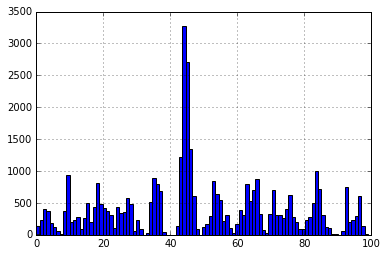

In [18]:
df['geobin'].hist(bins=100)

### Try things: plot geobin vs hour

In [19]:

def summarize(df):
    return df.groupby(['geobin','hour'])['hour'].count().unstack().fillna(0)

def plot_summary(summarized_data,vmin=None,vmax=None):
    plt.pcolor(summarized_data,vmin=vmin,vmax=vmax)
    plt.xlabel("Clearance Hour")
    plt.xlim([0,24])
    plt.ylim([0,df['geobin'].max()])
    plt.ylabel("Geobin")
    plt.title("Accidents: by hour and geobin")

In [20]:
df.keys()

Index([u'general_offense_number', u'event_clearance_code',
       u'event_clearance_description', u'event_clearance_subgroup',
       u'event_clearance_group', u'hundred_block_location', u'district_sector',
       u'zone_beat', u'census_tract', u'longitude', u'latitude',
       u'clearance_date', u'hour', u'date', u'geobin', u'good_weather',
       u'valid_time_gmt', u'precip_hrly', u'precip_total', u'wx_phrase'],
      dtype='object')

In [21]:
#We never got the weather merge working....
#good_weather = summarize(df[df['precip_total']==0])
#bad_weather = summarize(df[df['precip_total']!=0]
bad_weather = df[df['wx_phrase'].str.contains("Rain")]
good_weather = df[np.invert( df['wx_phrase'].str.contains("Rain"))]

#So over here we use the fake data instead. 
good_weather = summarize(df[df['good_weather']==0])
bad_weather = summarize(df[df['good_weather']!=0])

In [23]:
print good_weather.shape
print bad_weather.shape
print df.shape

(95, 24)
(94, 24)
(39131, 20)


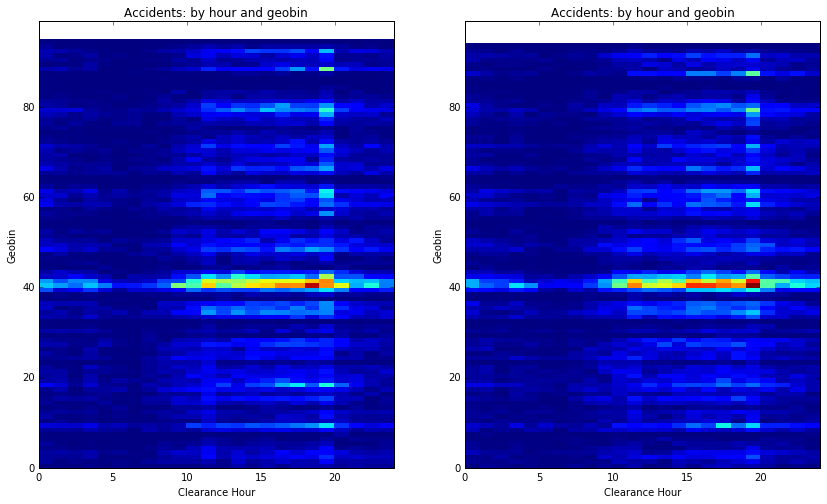

In [24]:
vmin=min(good_weather.as_matrix().min(),bad_weather.as_matrix().min())
vmax=max(good_weather.as_matrix().max(),bad_weather.as_matrix().max())

plt.figure().set_size_inches(14,8)
plt.title("Total number of accidents, good vs bad weather")
plt.subplot(1,2,1)
plot_summary(good_weather,vmin,vmax)
plt.subplot(1,2,2)
plot_summary(bad_weather,vmin,vmax)

<img src="http://brilliantbuthumble.com/share/cognitivebuilder/Slide06.jpg">

<img src="http://brilliantbuthumble.com/share/cognitivebuilder/Slide07.jpg">

<img src="http://brilliantbuthumble.com/share/cognitivebuilder/Slide08.jpg">

<img src="http://brilliantbuthumble.com/share/cognitivebuilder/Slide09.jpg">

<img src="http://brilliantbuthumble.com/share/cognitivebuilder/Slide11.jpg">

# Old code we may not use 

below this line

### Try things: Cluster Analysis by latitude / longitude

In [25]:
import sklearn.cluster

In [26]:
#latitude and longitude as numerics
import math
centroid=x.mean(0)
x['normalize_longitude']=x['longitude'] * math.cos(math.pi*2 * centroid['latitude'] / 360 )

In [27]:
kmeans_fit=sklearn.cluster.KMeans(n_clusters=20)
clusters=kmeans_fit.fit_predict(x[['latitude','normalize_longitude']])
x['cluster']=clusters
x=x.drop('normalize_longitude',axis=1)

### Saving files out for download

### I wrote bluemix_xfer to move files between object storage and the filesystem. 

It's `get` and `put` methods based on the sample code that the object storage generates. Not sharing here because it contains my API key

In [ ]:
import bluemix_xfer
x.to_csv("for_drew.csv")
bluemix_xfer.get_to_file("TrafficData","bluemix_xfer.py","bluemix_xfer.py")

In [28]:
lat= x['latitude'] 
long= x['longitude']
#clearance_times=x[' clearance_time']

In [29]:
colors = [ "red", "green", "yellow", "blue","orange", "teal","gray", "lightblue"]*2 + ["lightgray"]*20

This subset limits the display below

In [30]:
subset=slice(None,None,None) #Show everything
#subset=slice(None,None,10) #Decimate to 10%

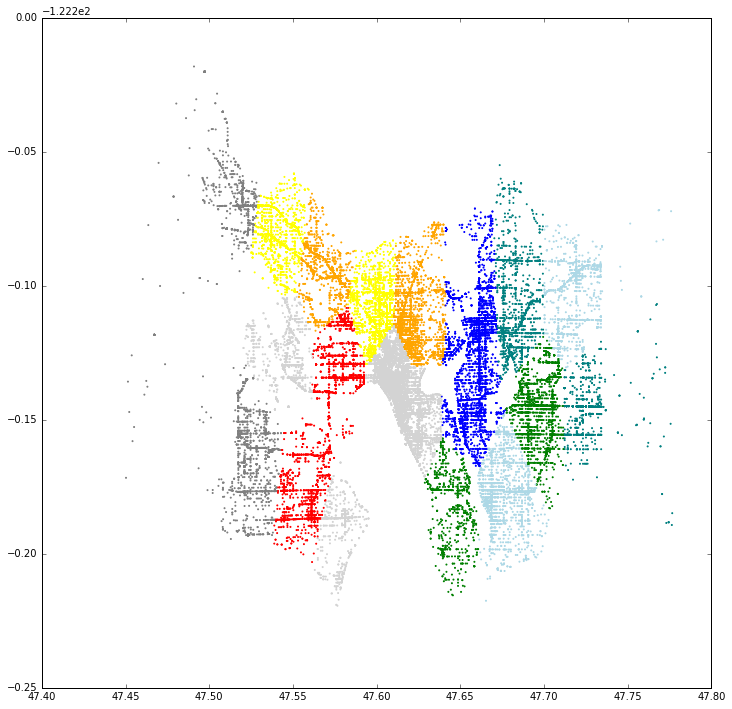

In [31]:
plt.figure().set_size_inches(12,12)
plt.scatter(lat[subset],long[subset],color=[ colors[cluster] for cluster in x['cluster'] ],s=1)

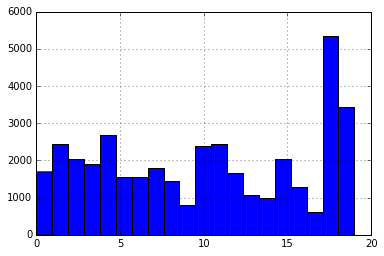

In [32]:
x['cluster'].hist(bins=20)

### Lat/Longitude code importing accident clusters into Tableau

<img src="http://brilliantbuthumble.com/share/cognitivebuilder/Slide12.jpg">